In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

In [2]:
from util_func import RunModel, calculate_expected_loss, visualize_joint_posterior, visualize_loss,calc_stats_between_buckets_for_column

## Compare prior distributions

In [3]:
# Input: alpha and beta as shape parameters
# conversion rate prior: uniform, 1%, 2%, 4%, 6%, 10%
priors = [(1,1), (2,100), (4, 98), (6,96), (8,94), (10, 92)]
_alpha, _beta = zip(*priors)

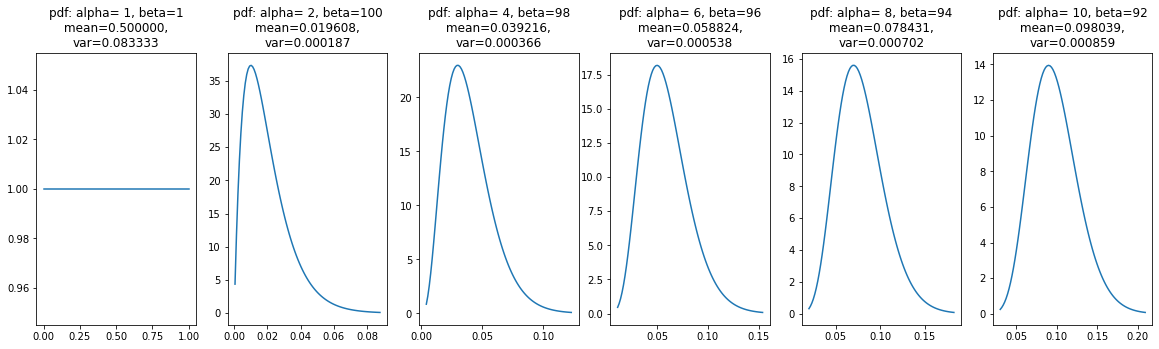

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,5))
for i in range(6):
    a, b = _alpha[i], _beta[i]
    mean, var = beta.stats(a, b)
    x = np.linspace(beta.ppf(0.001, a, b),
              beta.ppf(0.999,a,b), 100)
    ax = axes[i]
    ax.plot(x, beta.pdf(x, a, b))
    ax.title.set_text('pdf: alpha= %i, beta=%i\n mean=%f, \nvar=%f'%(a,b, mean, var))

## How does priors affect experiment runtime and results?

### Load model

In [5]:
conversion_model = """
data {
  int<lower=0> observations;            
  int<lower=0> observation_conversion_count;
  real<lower=0> prior_alpha;
  real<lower=0> prior_beta;
}

parameters {
  real<lower=0, upper=0.8> theta;
}

model {
  theta ~ beta(prior_alpha, prior_beta);
  observation_conversion_count ~ binomial(observations, theta);
}

"""
sm_conversion = pystan.StanModel(model_code = conversion_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97f75449d47461cb90cfbe6583c57f7b NOW.


### Generate simulations

In [14]:
def GenerateSimulationData(n_per_day,p1, p2):
    # Generate simulation data
    date_range = pd.date_range(start = '2020-01-01', periods = 30)
    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    for t in date_range:
        y1 = np.random.binomial(n=1, p=p1, size=n_per_day)
        y2 = np.random.binomial(n=1, p=p2, size=n_per_day) 
        dfy1 = pd.DataFrame(y1, columns=['is_converted'])
        dfy2 = pd.DataFrame(y2, columns=['is_converted'])
        dfy1['participation_timestamp_rounded_up'] = t
        dfy2['participation_timestamp_rounded_up'] = t
        df1 = pd.concat([df1, dfy1], axis =0)
        df2 = pd.concat([df2, dfy2], axis =0)

    df1['bucket'] = 'bucket1'
    df2['bucket'] = 'bucket2'
    df = pd.concat([df1, df2], axis = 0)
    return df

In [30]:
n_per_day = int(64796/2)
p1 = 0.05
p2 = p1 *(1.01)
df = GenerateSimulationData(n_per_day,p1, p2)

In [31]:
(p1-p2)/p2, p2

(-0.00990099009900991, 0.0505)

In [23]:
df.groupby('bucket').aggregate(['sum', 'count'])

is_converted        
                 sum   count
bucket                      
bucket1        48879  971940
bucket2        50726  971940

### Run model on different priors

In [18]:
metric = 'conversion'
stan_model = sm_conversion

### effect size = 5%

#### Uniform priors

/Users/juersong/Documents/seatgeek/bvf/util_func.py:32: RuntimeWarning: invalid value encountered in long_scalars
  print(y.sum()/len(y))


nan
nan
loss if choosing variant1: 0.13432579328328836
loss if choosing variant2: 0.1281802150987884
Bucket 1 quartiles: [0.01870579 0.162656   0.37312853 0.58873565 0.73300178]
Bucket 2 quartiles: [0.04020332 0.17744774 0.39208708 0.56161167 0.76180597]
0.048830174702142105
0.052441508735107105
loss if choosing variant1: 0.0036650544270452274
loss if choosing variant2: 1.0936133868180418e-05
Bucket 1 quartiles: [0.04697071 0.04804448 0.04884592 0.04963108 0.05092496]
Bucket 2 quartiles: [0.0505321  0.05170727 0.05252111 0.05323798 0.05469355]
It takes 2 day(s) to draw the conclusion


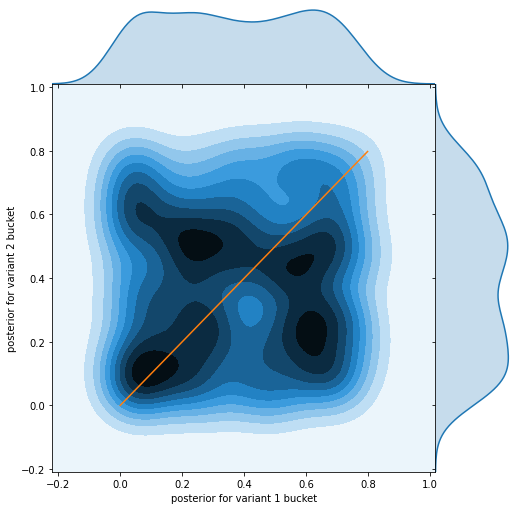

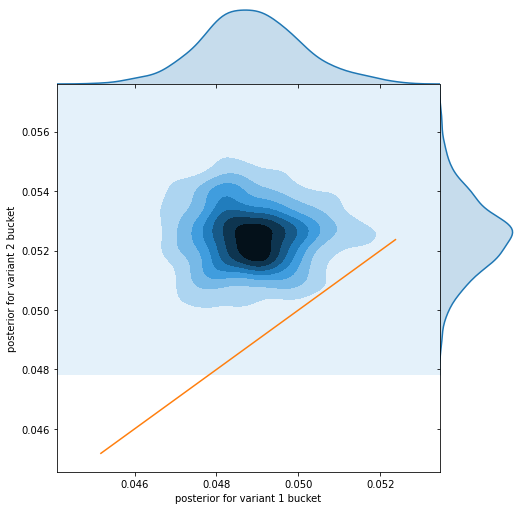

In [28]:
stats = []
num_days = 0
max_days = 5
err_thres = 0.0005
date_range=pd.date_range(start = '2020-01-01', periods = 30)
i=0
for ts in date_range:
    a, b = _alpha[i], _beta[i]
    closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
    stats.append((closs, tloss))
    num_days += 1
    
    if closs < err_thres or tloss < err_thres:
        print(f'It takes {num_days} day(s) to draw the conclusion')
        break

#### beta (6,96)

/Users/juersong/Documents/seatgeek/bvf/util_func.py:32: RuntimeWarning: invalid value encountered in long_scalars
  print(y.sum()/len(y))


nan
nan
loss if choosing variant1: 0.01381607054596768
loss if choosing variant2: 0.014070137782059223
Bucket 1 quartiles: [0.02360294 0.04459259 0.05749303 0.07339739 0.10676584]
Bucket 2 quartiles: [0.0272008  0.04164822 0.05608543 0.07579397 0.10351593]
0.048830174702142105
0.052441508735107105
loss if choosing variant1: 0.00338891980951011
loss if choosing variant2: 9.234426587066302e-06
Bucket 1 quartiles: [0.04679832 0.04813577 0.04889928 0.04978302 0.05080789]
Bucket 2 quartiles: [0.05026881 0.05142518 0.05233698 0.05317757 0.05436644]
It takes 2 day(s) to draw the conclusion


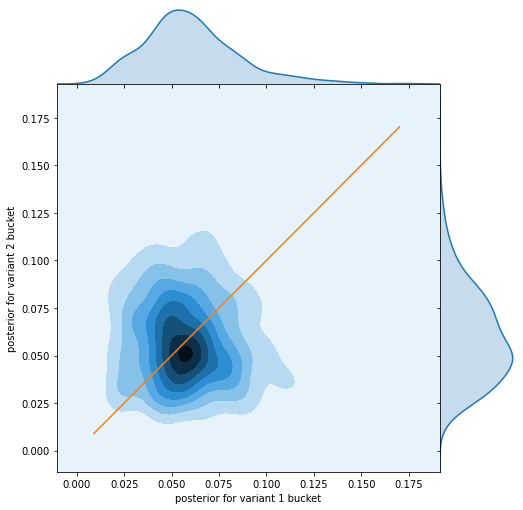

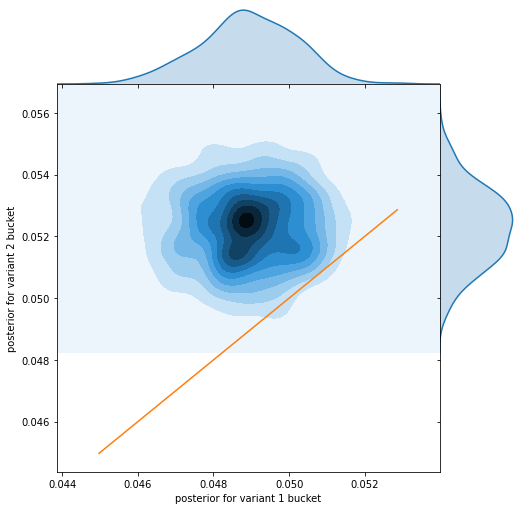

In [29]:
stats = []
num_days = 0
max_days = 5
err_thres = 0.0005
date_range=pd.date_range(start = '2020-01-01', periods = 30)
i=3
for ts in date_range:
    a, b = _alpha[i], _beta[i]
    closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
    stats.append((closs, tloss))
    num_days += 1
    
    if closs < err_thres or tloss < err_thres:
        print(f'It takes {num_days} day(s) to draw the conclusion')
        break

### effect size = 1%

#### uniform priors

/Users/juersong/Documents/seatgeek/bvf/util_func.py:32: RuntimeWarning: invalid value encountered in long_scalars
  print(y.sum()/len(y))


nan
nan
loss if choosing variant1: 0.12800651140822855
loss if choosing variant2: 0.14820287490483744
Bucket 1 quartiles: [0.03898691 0.19329472 0.37095162 0.60695152 0.75143677]
Bucket 2 quartiles: [0.03313292 0.16744337 0.35808514 0.57935437 0.74879424]
0.04932403234767578
0.050651274770047536
loss if choosing variant1: 0.0015069182039495073
loss if choosing variant2: 0.00016006514860389187
Bucket 1 quartiles: [0.04758068 0.04859436 0.04935546 0.0500861  0.05113111]
Bucket 2 quartiles: [0.04896786 0.0498116  0.05066896 0.05144199 0.05259892]
It takes 2 day(s) to draw the conclusion


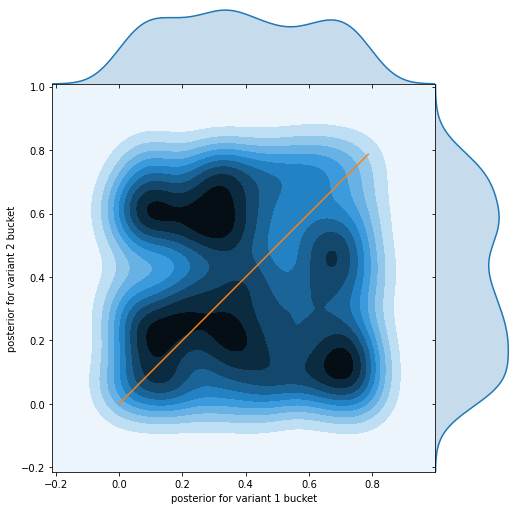

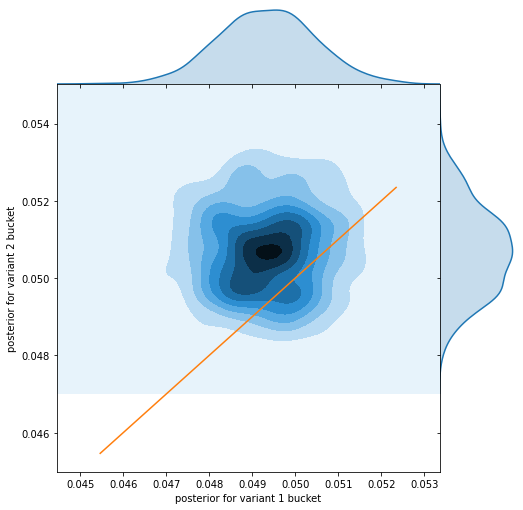

In [32]:
stats = []
num_days = 0
max_days = 30
err_thres = 0.0005
date_range=pd.date_range(start = '2020-01-01', periods = 30)
i=0
for ts in date_range:
    a, b = _alpha[i], _beta[i]
    closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
    stats.append((closs, tloss))
    num_days += 1
    
    if closs < err_thres or tloss < err_thres:
        print(f'It takes {num_days} day(s) to draw the conclusion')
        break

In [ ]:
num_days=2
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In this simulation, when we use uniform priors, it takes 2 days to make (the right) conclusion.

In [ ]:
num_days=3
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha = 2, beta =100, mean_cvr =1%

In [ ]:
# Alpha = 2, beta =100, cvr =1%
stats = []
err_thres = 0.0005

i=1
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=2
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=3
ts=date_range[num_days]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha = 4, beta =98, mean_cvr =3%

In [ ]:
# Alpha = 4, beta =98, cvr =3%
stats = []
err_thres = 0.0005

i=2
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha=6, Beta=96, mean_cvr= 5%

In [ ]:
# Alpha = 6, beta =96, cvr =5%
stats = []
err_thres = 0.0005

i=3
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

#### Alpha=8, Beta=94, mean_cvr= 7%

In [ ]:
# Alpha = 8, beta =94, cvr =7%
stats = []
err_thres = 0.0005

i=4
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=3
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
#### Alpha=8, Beta=94, mean_cvr= 7%

In [ ]:
# Alpha = 10, beta =92, cvr =9%
stats = []
err_thres = 0.0005

i=5
a, b = _alpha[i], _beta[i]

num_days=1
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=2
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')

In [ ]:
num_days=3
ts=date_range[num_days]

closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True, a,b)
stats.append((closs, tloss))
    
if closs < err_thres or tloss < err_thres:
    print(f'It takes {num_days} day(s) to draw the conclusion')